# Rendu TP - Orr-Sommerfeld
## Marine Prunier, Noé Durandard

On considère un écoulement de Poiseuil perturbé en deux dimension, dans un tube de largeur 2L. 
On cherche à modéliser l'évolution de l'amplitude de la perturbation initiale $v'(y,t)$.

In [19]:
import numpy 
import scipy
from scipy import linalg
from matplotlib import pyplot
%matplotlib inline
from matplotlib import cm, animation
from IPython.display import HTML
from math import * 

On commence par discrétiser l'environnement du problème en temps et en espace. 


In [20]:
N=101 #Nombre de points sur la largeur du cylindre
L=1.0 #Rayon du cylindre 
nt = 100  #Nombre de pas de temps
y=numpy.linspace(-L,L,N) #Grille spatiale
dy=2*L/(N-1) #Pas d'espace

On initialise la perturbation initiale que l'on cherche à faire évoluer.
Le problème contient 4 conditions aux bords: 
Deux conditions de Dirichlet et deux conditions de von Neumann aux bords du cylindre.
On adopte une "forward finite difference" du second ordre pour la dérivée première sur le bord $y=-L$ et une "backward finite difference" du second ordre pour la dérivée première sur le bord $y=L$.
/détail à mettre 

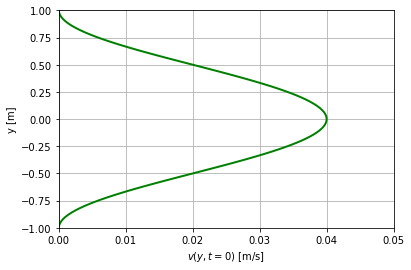

In [21]:
vinit=numpy.empty(N,dtype=numpy.complex_)
for i in range(N):
    vinit[i]=0.02*(1+cos(pi*y[i]))
    
# Conditions aux bords.
vinit[0]=0
vinit[N-1]=0
vinit[1]=vinit[2]/4
vinit[N-2]=vinit[N-3]/4 

# Graphique de la norme de la perturbation initiale.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('$v(y,t=0)$ [m/s]')
pyplot.ylabel('y [m]')
pyplot.grid()
pyplot.plot(abs(vinit), y, color='green', linestyle='-', linewidth=2)
pyplot.xlim(0.0, 0.05)
pyplot.ylim(-L, L);

On initialise deux opérateurs, D2_v et D4_v, du type "central finite difference" valables respectivement à l'ordre 2 et 4 et qui agissent sur les valeurs indépendantes de $v'(y,t)$.
Ces derniers permettront d'implémenter l'opérateur d'évolution temporelle.  

In [22]:
def D2_v(N,dy):

    # Initialisation de la diagonale centrale.
    D = numpy.diag((-2.0) * numpy.ones(N-4))
    # Initialisation de la diagonale supérieure.
    U = numpy.diag(1.0 * numpy.ones(N - 5), k=1)
    # Initialisation de la diagonale inférieure.
    L = numpy.diag(1.0 * numpy.ones(N - 5), k=-1)
    
    #Assemblage de l'opérateur.
    D2_v = D + U + L
    
    #Conditions de bord.
    D2_v[0][0] = -7/4
    D2_v[-1][-1] = -7/4
    
    
    D2_v = ((1/dy)**2)*D2_v
    
    return D2_v

print(D2_v(101,0.02))

[[-4375.  2500.     0. ...     0.     0.     0.]
 [ 2500. -5000.  2500. ...     0.     0.     0.]
 [    0.  2500. -5000. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... -5000.  2500.     0.]
 [    0.     0.     0. ...  2500. -5000.  2500.]
 [    0.     0.     0. ...     0.  2500. -4375.]]


In [23]:
def D4_v(N,dy):
    
    # Initialisation de la diagonale centrale.
    D = numpy.diag((6.0) * numpy.ones(N-4))
    # Initialisation de la diagonale supérieure.
    U = numpy.diag(-4.0 * numpy.ones(N - 5), k=1)
    # Initialisation de la diagonale inférieure.
    L = numpy.diag(-4.0 * numpy.ones(N - 5), k=-1)
    # Initialisation de la diagonale supérieure+1.
    U2 = numpy.diag(1.0 * numpy.ones(N - 6), k=2)
    # Initialisation de la diagonale inférieure-1.
    L2 = numpy.diag(1.0 * numpy.ones(N - 6), k=-2)
    
    # Assemblage de l'opérateur.
    D4_v = D + U + L + U2 + L2
    
    # Conditions de bord.
    D4_v[0][0] = 5
    D4_v[-1][-1] = 5
    
    D4_v[1][0] = -15/4
    D4_v[-2][-1] = -15/4
    
    D4_v = ((1/dy)**4)*D4_v
    
    return D4_v

print(D4_v(101,0.02))
    

[[ 31250000. -25000000.   6250000. ...         0.         0.         0.]
 [-23437500.  37500000. -25000000. ...         0.         0.         0.]
 [  6250000. -25000000.  37500000. ...         0.         0.         0.]
 ...
 [        0.         0.         0. ...  37500000. -25000000.   6250000.]
 [        0.         0.         0. ... -25000000.  37500000. -23437500.]
 [        0.         0.         0. ...   6250000. -25000000.  31250000.]]


On définit l'opérateur d'évolution $L_v$ tel que :
 
 $$\frac{\partial}{\partial t} \hat{v}^{\prime}=L \hat{v}^{\prime}$$

correspondant à la formule suivante: 

$$L=\left(D^{2}-\alpha^{2}\right)^{-1}\left\{-i \alpha U\left(D^{2}-\alpha^{2}\right)+i \alpha U^{\prime \prime}+\frac{1}{R}\left(D^{2}-\alpha^{2}\right)^{2}\right\}$$
    

In [24]:
def L_v(N,y,dy,R,alpha):
    
    D2 = D2_v(N,dy)
    D4 = D4_v(N,dy)
    
    A=(D2-alpha**2*numpy.identity(N-4))
    K=linalg.inv(A)
    
    profile=numpy.zeros(N) 
    profile[:] = 1 - y[:]*y[:]
    
    U= numpy.diag(profile[2:-2])
    U2= -2*numpy.identity(N-4)
    
    L = K.dot( (-1j*alpha*U.dot(A)) + 1j*alpha*U2 + (1/R)*(D4-2*alpha*alpha*D2 + numpy.identity(N-4)*alpha**4) )
                    

    return L


On définit la fonction Runge Kutta ordre 4 qui va nous permettre de faire évoluer la perturbation en intégrant $L_v\cdot v'(y,t)$.

In [25]:
def RK4Sys2(operator, tf, vinit, dt):
    
    v=vinit.copy()
    for t in range (int(tf/dt)):
        k1 = dt*operator.dot(v)
        k2 = dt*operator.dot(v + k1/2.0)
        k3 = dt*operator.dot(v + k2/2.0)
        k4 = dt*operator.dot(v + k3)
        v += (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
    
    return v

On teste le programme avec un pas de temps de $dt=0.01$ et un temps final $t_f=10$s. L'évolution de la perturbation est simulée à partir de la condition initiale $v'(y,t=0)$ définie plus haut. La valeur de la perturbation simulée au temps final en $y=0.5$ peut ainsi être comparée avec la valeur de référence: ${\hat v}'(0.5)=0.00772852-0.01239437i$.

En y=0.5, la simulation donne v'( 0.5 ) =  (0.0077285235607835335-0.012394369382355242j)


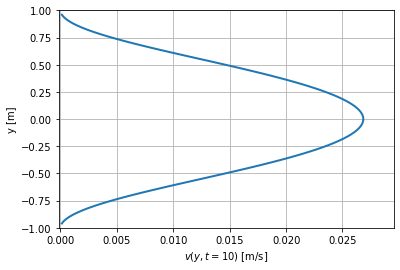

In [26]:
dt= 0.01 #Pas de temps
tf = 10 #Nombre de Reynolds
R = 500   #Angle initial
alpha = 0.3    

# Intégration du système par RK4.
v = RK4Sys2(L_v(N,y,dy,R,alpha),tf,vinit[2:-2],dt)

print("En y=0.5, la simulation donne v'(",y[numpy.argmin(abs(y-0.5))],') = ',v[numpy.argmin(abs(y-0.5))-2])

# Graphique de la norme de la perturbation à t=10s.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('$v(y,t=10)$ [m/s]')
pyplot.ylabel('y [m]')
pyplot.grid()
pyplot.plot(abs(v), y[2:-2], color='C0', linestyle='-', linewidth=2)
pyplot.xlim(min(abs(v))-max(abs(v))/100, max(abs(v))+max(abs(v))/10)
pyplot.ylim(-L, L);



A partir de l'équation $\frac{\partial}{\partial t} X(t)=L X(t), \text { avec } X(0)=I$ on calcule le propagateur $X$ à l'instant $t=10$ pour les mêmes valeurs des paramètres que précédemment, en utilisant l'algorithme RK4. 

On peut ensuite comparer les résultats obtenus en faisant directement évoluer la perturbation par RK4 ou avec l'utilisation du propagateur.

Différence maximale : max|X(10)v'(0)-v'(10)|= 3.1031676915590914e-17


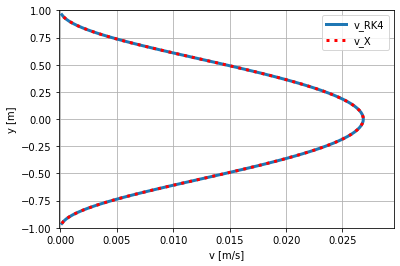

In [33]:
# Initialisation du propagateur.
Xinit = numpy.identity(N-4,dtype=numpy.complex_)

# Intégration du propagateur.
Xfunc = RK4Sys2(L_v(N,y,dy,R,alpha),tf,Xinit,dt)

# Calcul de la perturbation au temps final via le propagateur.
v_prop = Xfunc.dot(vinit[2:-2])


# Graphique/comparaison de la norme de la perturbation calculée avec RK4 ou le propagateur.  
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('v [m/s]')
pyplot.ylabel('y [m]')
pyplot.grid()
pyplot.plot(abs(v), y[2:-2], color='C0', linestyle='-', linewidth=3, label="v_RK4")
pyplot.plot(abs(v_prop), y[2:-2], color='red', linestyle=':', linewidth=3, label="v_X")
pyplot.legend(loc="upper right")
pyplot.xlim(min(abs(v_prop))-max(abs(v_prop))/100, max(abs(v_prop))+max(abs(v_prop))/10)
pyplot.ylim(-L, L);



print("Différence maximale : max|X(10)v'(0)-v'(10)|=", max(abs(v_prop-v)))

L'erreur trouvée étant très petite (proche de la précision machine), on observe bien que la norme de la perturbation calculée soit avec le propagateur ou sans propagateur aboutit bien à la même évolution de la perturbation au temps final. 

On effectue la décomposition singulière du propagateur obtenu et on calcule la plus grande des valeurs sigulières. Puis on trace la perturbation optimale correspondante au vecteur d'entrée associé à cette plus grande valeur singulière.

s = 3.304238341476203


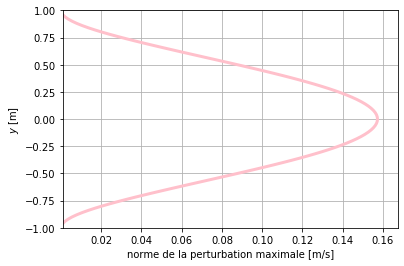

In [38]:
u,s,vh = numpy.linalg.svd(Xfunc)
print("s =",numpy.amax(s))

pert_max = u[:,numpy.argmax(s)]

# Graphique de la perturbation optimale.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('norme de la perturbation maximale [m/s]')
pyplot.ylabel('$y$ [m]')
pyplot.grid()
pyplot.plot(abs(pert_max),y[2:-2], color='pink', linestyle='-', linewidth=3)
pyplot.xlim(min(abs(pert_max)), max(abs(pert_max)+0.01))
pyplot.ylim(min(y), max(y));

On fait varier $\alpha$ comme paramètre dans le propagateur, et on cherche à déterminer la valeur de $\alpha$ qui maximise l'amplification des perturbations à l'instant $t=10$.
Pour cela on commence par faire un graphique de l'amplification des perturbations avec un nombre de $\alpha$ limité variant entre 0 et $2\pi$, pour avoir un vision générale du profil de l'amplification des perturbations en fonction d'$\alpha$. 

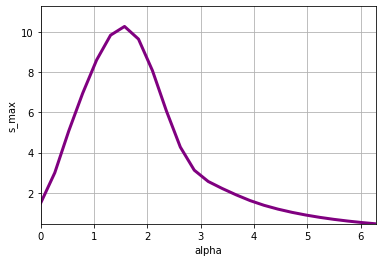

In [41]:
n_alpha = 25 #nombre de points testés

a_min = 0
a_max = 2*pi
a=numpy.linspace(a_min,a_max,n_alpha)

s_max = numpy.zeros(n_alpha)


Xinit = numpy.identity(N-4,dtype=numpy.complex_)

for i in range(n_alpha):
    u,s,vh = numpy.linalg.svd(RK4Sys2(L_v(N,y,dy,R,a[i]),tf,Xinit,dt))
    s_max[i] = max(abs(s))
 
 # Graphique de l'amplification des perturbations en fonction d'alpha.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.ylabel('s_max')
pyplot.xlabel('alpha')
pyplot.grid()
pyplot.plot(a, s_max, color='purple', linestyle='-', linewidth=3)
pyplot.xlim(a[0], a[n_alpha-1])
pyplot.ylim(min(s_max), max(s_max)+1);

Pour trouver $\alpha_{max}$ de manière plus précise, sans pour autant tester trop de valeurs de $\alpha$ dans des domaines éloignés du paramètre maximisant l'amplification des perturbations à $t_f$, on implémente une méthode testant des valeurs de $\alpha$ de plus en plus serrées autour de la valeur $\alpha_{max}$ recherchée. Ainsi on effectue $n_{loop}$ boucles, en testant à chaque boucle $n_{a,while}$ valeurs de $\alpha$. D'une boucle à la prochaine, l'intervalle des $\alpha$ testés se resserre sur la valeur de $\alpha_{max,loop}$ correspondant à la valeur de $\alpha$ testée donnant la plus grande amplification de la perturbation.

In [44]:
n_loop = 4 #Nombre de boucles (impactant la précision).
n = 1 #Paramètre d'itération.

n_a_while = 15 # Nombre de valeurs de alpha testées par boucle. 

# Plage initiale des alpha (1ère boucle).
a_min_while = 0 
a_max_while = 2*pi

s_max_while = numpy.zeros(n_a_while) 

Xinit = numpy.identity(N-4,dtype=numpy.complex_) # Initialisation du propagateur.

while (n<=n_loop):
    
    a_while=numpy.linspace(a_min_while,a_max_while,n_a_while)
    
    for i in range(n_a_while):
        # Décomposition en valeurs singulières
        u,s,vh = numpy.linalg.svd(RK4Sys2(L_v(N,y,dy,R,a_while[i]),tf,Xinit,dt))
        s_max_while[i] = max(abs(s))
    
    # On ressert l'intervalle des valeurs de alpha testées pour la prochaine boucle.
    
    # Valeur de alpha maximisant l'amplitude des perturbation pour l'intervalle testé.
    a_sup = a_while[numpy.argmax(s_max_while)]
    # On réduit notre intervalle(arbitrairement d'une fraction 1/5) autour de alpha = a_sup.
    delta = (a_max_while - a_min_while)/5
    
    if (a_sup - delta < 0):
        a_min_while = 0
    else :
        a_min_while = a_sup - delta
    if (a_sup + delta > 2*pi):
        a_max_while = 2*pi
    else:
        a_max_while = a_sup + delta
        
    n += 1
    
print("Alpha maximisant la perturbation",a_while[numpy.argmax(s_max_while)])

Alpha maximisant la perturbation 1.5546395645764348


On peut alors représenter l'amplitude maximale de la perturbation en fonction du paramètre $\alpha$. Une régression quadratique (justifiée par la forme de la courbe) sur les dernières valeurs déterminées par la boucle permet d'affiner la valeur de $\alpha_{max}$ identifiée numériquement.  

Alpha maximisant la perturbation selon la régression quadratique:  1.5482566461691412


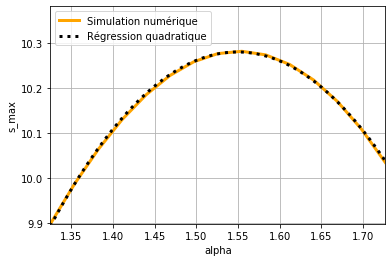

In [57]:
p=numpy.polyfit(a_while, s_max_while,2) # Calcul des coef de la régression quadratique.

a_fit = numpy.linspace(a_while[0],a_while[n_a_while-1], 100) #Intervalle du fit
fit = p[0]*a_fit**2+p[1]*a_fit+p[2] #Mise en forme du fit quadratique.

# Graphique autour de l'alpha maximisant l'amplitude de la perturbation.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.ylabel('s_max')
pyplot.xlabel('alpha')
pyplot.grid()
pyplot.plot(a_while, s_max_while, color='orange', linestyle='-', linewidth=3, label='Simulation numérique')

pyplot.plot(a_fit, fit, color='black', linestyle=':', linewidth=3, label='Régression quadratique')

pyplot.xlim(a_while[0], a_while[n_a_while-1])
pyplot.ylim(min(s_max_while), max(s_max_while)+1/10);
pyplot.legend(loc="upper left")



print("Alpha maximisant la perturbation selon la régression quadratique: ",a_fit[numpy.argmax(fit)])